In [1]:
from tensorflow.python.client import device_lib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pathlib
import time

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
batch_size = 32
img_height = 180
img_width = 180

In [4]:
data_dir = pathlib.Path("Data/cell_images")
# image_count = len(list(data_dir.glob(".\\*.png")))
image_count = len(list(data_dir.glob("*\\*.png")))

In [5]:
image_count

27558

In [6]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [7]:
for f in list_ds.take(5):
    print(f.numpy())

b'Data\\cell_images\\Uninfected\\C189P150ThinF_IMG_20151203_141308_cell_41.png'
b'Data\\cell_images\\Uninfected\\C231ThinF_IMG_20151112_153246_cell_121.png'
b'Data\\cell_images\\Parasitized\\C111P72ThinF_IMG_20150930_113610_cell_203.png'
b'Data\\cell_images\\Uninfected\\C1_thinF_IMG_20150604_104722_cell_143.png'
b'Data\\cell_images\\Uninfected\\C91P52ThinF_IMG_20150821_125154_cell_70.png'


In [8]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['Parasitized' 'Uninfected']


In [9]:
val_size = int(image_count *0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [10]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

22047
5511


# Function Definitions

In [11]:
def gel_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

In [12]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

In [13]:
def process_path(file_path):
    label = gel_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
# Set 'num_parallel_calls' so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls = AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls= AUTOTUNE)

In [15]:
for image, label in train_ds.take(1):
    print("Image Shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image Shape:  (180, 180, 3)
Label:  0


In [16]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size = 1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size = AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

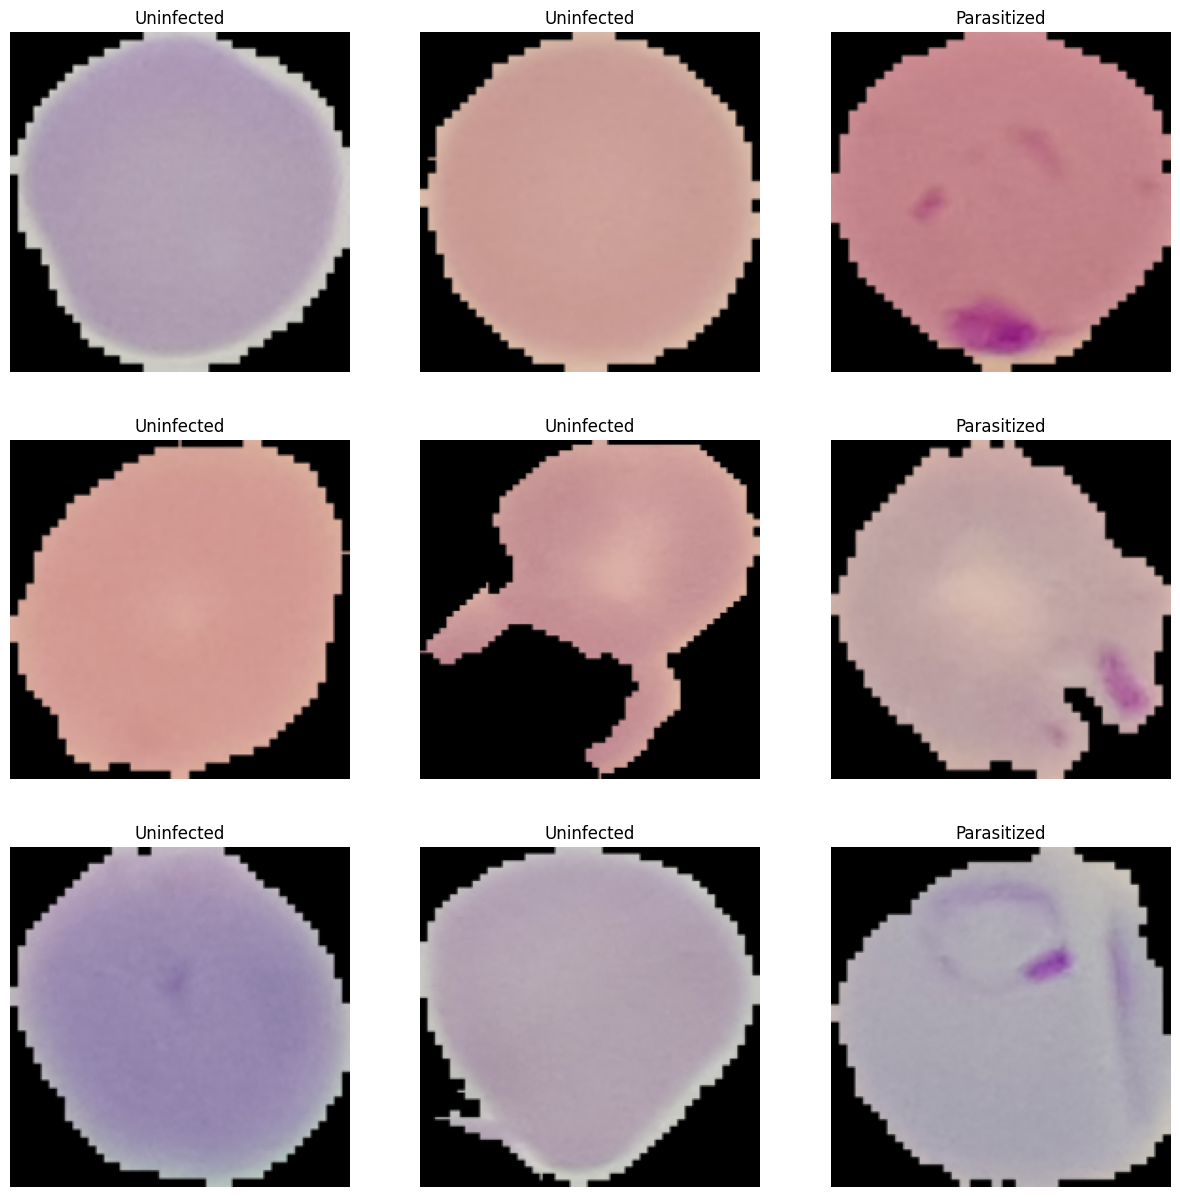

In [17]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(15,15))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [18]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [19]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [20]:
t1 = time.time()
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)
t2 = time.time()
print(t2-t1)

Epoch 1/20
689/689 [==============================] - 31s 34ms/step - loss: 0.3815 - accuracy: 0.8206 - val_loss: 0.1789 - val_accuracy: 0.9398
Epoch 2/20
689/689 [==============================] - 37s 53ms/step - loss: 0.1883 - accuracy: 0.9396 - val_loss: 0.1715 - val_accuracy: 0.9445
Epoch 3/20
689/689 [==============================] - 22s 33ms/step - loss: 0.1438 - accuracy: 0.9538 - val_loss: 0.1457 - val_accuracy: 0.9546
Epoch 4/20
689/689 [==============================] - 20s 29ms/step - loss: 0.1173 - accuracy: 0.9611 - val_loss: 0.1433 - val_accuracy: 0.9543
Epoch 5/20
689/689 [==============================] - 20s 29ms/step - loss: 0.0926 - accuracy: 0.9677 - val_loss: 0.1488 - val_accuracy: 0.9535
Epoch 6/20
689/689 [==============================] - 20s 29ms/step - loss: 0.0685 - accuracy: 0.9761 - val_loss: 0.1782 - val_accuracy: 0.9521
Epoch 7/20
689/689 [==============================] - 20s 29ms/step - loss: 0.0521 - accuracy: 0.9827 - val_loss: 0.2287 - val_accuracy: